# EDA: events360.jsonl

This notebook explores StatsBomb processed 360 event data.


In [26]:
from pathlib import Path
import json
import math
import statistics as stats
from collections import Counter, defaultdict

DATA_PATH = Path('open-data/data/processed/events360_v2.jsonl')
print(DATA_PATH.resolve())


/Users/ziyuelin/Library/Mobile Documents/com~apple~CloudDocs/University/UToronto/STA2453/MLSE/open-data/data/processed/events360_v2.jsonl


In [27]:
# Quick sanity check: number of lines
# Note: counting lines is I/O heavy but ok for a single pass.

line_count = 0
with DATA_PATH.open('r', encoding='utf-8') as f:
    for _ in f:
        line_count += 1

print('Total events (lines):', line_count)


Total events (lines): 306890


In [28]:
# Parse data in one pass and build stats.

players = set()
matches = set()
player_event_counts = Counter()
match_event_counts = Counter()
event_type_counts = Counter()

freeze_frame_counts = []
visible_area_sizes = []

# Helper: polygon area for visible_area
def polygon_area(coords):
    if not coords or len(coords) < 3:
        return None
    # coords is list of [x, y]
    area = 0.0
    for i in range(len(coords)):
        x1, y1 = coords[i]
        x2, y2 = coords[(i + 1) % len(coords)]
        area += (x1 * y2) - (x2 * y1)
    return abs(area) / 2.0

with DATA_PATH.open('r', encoding='utf-8') as f:
    for line in f:
        obj = json.loads(line)

        # Player and match identifiers
        player = obj.get('player') or {}
        if not isinstance(player, dict):
            player = {}
        player_id = obj.get('player_id') or player.get('id')
        match_id = obj.get('match_id')
        if player_id is not None:
            players.add(player_id)
            player_event_counts[player_id] += 1
        if match_id is not None:
            matches.add(match_id)
            match_event_counts[match_id] += 1

        # Event type distribution
        ev_type = obj.get('type')
        if isinstance(ev_type, dict):
            ev_type = ev_type.get('name')
        event_type_counts[ev_type] += 1

        # 360 analysis
        freeze_frame = obj.get('freeze_frame')
        if isinstance(freeze_frame, list):
            freeze_frame_counts.append(len(freeze_frame))
        else:
            # If missing, treat as 0 for distribution clarity
            freeze_frame_counts.append(0)

        visible_area = obj.get('visible_area')
        # Some datasets store visible_area as a list of numbers [x1, y1, x2, y2, ...]
        if isinstance(visible_area, list) and visible_area:
            # Try to interpret as list of [x, y]
            if isinstance(visible_area[0], list):
                coords = visible_area
            else:
                # Flattened list
                coords = list(zip(visible_area[0::2], visible_area[1::2]))
            area = polygon_area(coords)
            if area is not None:
                visible_area_sizes.append(area)

print('Unique players:', len(players))
print('Unique matches:', len(matches))


Unique players: 1090
Unique matches: 97


In [29]:
# Distribution summaries

def describe_counts(counter):
    values = list(counter.values())
    if not values:
        return {}
    return {
        'min': min(values),
        'p25': stats.quantiles(values, n=4)[0],
        'median': stats.median(values),
        'p75': stats.quantiles(values, n=4)[2],
        'max': max(values),
        'mean': sum(values) / len(values),
    }

player_counts_summary = describe_counts(player_event_counts)
match_counts_summary = describe_counts(match_event_counts)

print('Events per player summary:', player_counts_summary)
print('Events per match summary:', match_counts_summary)


Events per player summary: {'min': 1, 'p25': 69.75, 'median': 194.0, 'p75': 405.5, 'max': 2019, 'mean': 281.53119266055046}
Events per match summary: {'min': 2269, 'p25': 2869.5, 'median': 3124, 'p75': 3309.5, 'max': 4456, 'mean': 3163.814432989691}


In [30]:
# Top players and matches by event volume

print('Top 10 players by event count:')
for pid, cnt in player_event_counts.most_common(10):
    print(pid, cnt)

print('Top 10 matches by event count:')
for mid, cnt in match_event_counts.most_common(10):
    print(mid, cnt)


Top 10 players by event count:
30486 2019
4353 1990
3244 1875
3570 1856
5211 1821
6892 1628
7024 1595
3382 1525
3336 1459
3959 1439
Top 10 matches by event count:
3794685 4456
3795506 4303
3795221 4249
3795220 4247
3794686 4244
3794692 4236
3795108 4220
3844387 4065
3794691 3970
3857255 3968


In [31]:
# Event type distribution (top 20)

print('Top 20 event types:')
for ev, cnt in event_type_counts.most_common(50):
    print(ev, cnt)


Top 20 event types:
Pass 84951
Ball Receipt* 83657
Carry 72307
Pressure 25382
Ball Recovery 8366
Duel 5886
Clearance 3927
Block 3211
Interception 2612
Dribble 2569
Shot 2436
Miscontrol 2351
Foul Committed 2105
Foul Won 1994
Dispossessed 1854
Dribbled Past 1524
Goal Keeper 1440
50/50 154
Shield 73
Error 38
Offside 19
Own Goal Against 13
Own Goal For 13
Referee Ball-Drop 8


In [32]:
# Attribute breakdowns per event type
# This builds distributions like: 50/50 -> outcome: Won/Lost counts

from collections import defaultdict

# Map event type name to likely JSON key
# StatsBomb event type names -> JSON sub-dict keys

def type_to_key(type_name: str):
    if type_name is None:
        return None
    # normalize
    name = type_name.replace('*', '').replace('/', '_').replace(' ', '_').lower()
    # special cases
    if name == '50_50':
        return '50_50'
    if name == 'goal_keeper':
        return 'goalkeeper'
    return name

# Collect attribute distributions
attr_counts = defaultdict(lambda: defaultdict(Counter))

with DATA_PATH.open('r', encoding='utf-8') as f:
    for line in f:
        obj = json.loads(line)
        t = obj.get('type')
        if isinstance(t, dict):
            t = t.get('name')
        key = type_to_key(t)
        if not key:
            continue
        details = obj.get(key)
        if not isinstance(details, dict):
            continue
        for attr, val in details.items():
            if val is None:
                continue
            # Normalize values
            if isinstance(val, dict):
                if 'name' in val:
                    val = val['name']
                elif 'id' in val:
                    val = val['id']
                else:
                    val = str(val)
            elif isinstance(val, list):
                # Skip lists to avoid huge or unhelpful dumps (e.g., freeze_frame)
                continue
            attr_counts[t][attr][val] += 1

# Display results for selected event types (edit this list as needed)
selected_types = ['50/50', 'Foul Committed', 'Foul Won', 'Duel', 'Pass', 'Shot', 'Dribble', 'Ball Recovery', 'Block', 'Goal Keeper']

for t in selected_types:
    if t not in attr_counts:
        print(f"{t}: no attribute data found")
        continue
    print(f"{t}")
    for attr, counter in attr_counts[t].items():
        # Show top 10 values per attribute
        top = counter.most_common(10)
        print(f"  {attr}: {top}")


50/50
  outcome: [('Lost', 77), ('Success To Team', 31), ('Won', 27), ('Success To Opposition', 19)]
Foul Committed
  advantage: [(True, 260)]
  card: [('Yellow Card', 201), ('Red Card', 4), ('Second Yellow', 2)]
  penalty: [(True, 30)]
  type: [('Handball', 96), ('Dangerous Play', 12), ('Foul Out', 4), ('Dive', 3)]
  offensive: [(True, 56)]
Foul Won
  advantage: [(True, 252)]
  defensive: [(True, 589)]
  penalty: [(True, 23)]
Duel
  outcome: [('Success In Play', 951), ('Won', 745), ('Lost In Play', 657), ('Lost Out', 450), ('Success Out', 92)]
  type: [('Aerial Lost', 2991), ('Tackle', 2895)]
Pass
  length: [(9.708244, 35), (8.5, 34), (11.543396, 34), (14.866069, 32), (7.940403, 32), (8.13941, 30), (7.4330344, 29), (16.62077, 27), (9.80816, 27), (15.654073, 27)]
  angle: [(0.0, 484), (1.5707964, 383), (-1.5707964, 348), (3.1415927, 219), (-0.7853982, 103), (0.7853982, 101), (-1.1071488, 73), (-2.3561945, 69), (-0.4636476, 67), (2.3561945, 64)]
  height: [('Ground Pass', 61037), ('High

In [33]:
# Freeze frame counts summary

if freeze_frame_counts:
    ff_summary = {
        'min': min(freeze_frame_counts),
        'p25': stats.quantiles(freeze_frame_counts, n=4)[0],
        'median': stats.median(freeze_frame_counts),
        'p75': stats.quantiles(freeze_frame_counts, n=4)[2],
        'max': max(freeze_frame_counts),
        'mean': sum(freeze_frame_counts) / len(freeze_frame_counts),
    }
    print('Freeze frame count summary:', ff_summary)
else:
    print('No freeze_frame data found.')


Freeze frame count summary: {'min': 1, 'p25': 13.0, 'median': 15.0, 'p75': 18.0, 'max': 22, 'mean': 14.893636156277493}


In [34]:
# Visible area sizes summary

if visible_area_sizes:
    va_summary = {
        'min': min(visible_area_sizes),
        'p25': stats.quantiles(visible_area_sizes, n=4)[0],
        'median': stats.median(visible_area_sizes),
        'p75': stats.quantiles(visible_area_sizes, n=4)[2],
        'max': max(visible_area_sizes),
        'mean': sum(visible_area_sizes) / len(visible_area_sizes),
    }
    print('Visible area size (polygon area) summary:', va_summary)
else:
    print('No visible_area data found.')


Visible area size (polygon area) summary: {'min': 349.8734317480987, 'p25': 1973.1875656593702, 'median': 2493.134977031473, 'p75': 3168.2396790034545, 'max': 8633.346419200843, 'mean': 2639.875892739351}


In [35]:
# Optional: histogram-like bins for quick inspection

# Freeze frames
ff_bins = Counter()
for c in freeze_frame_counts:
    if c == 0:
        ff_bins['0'] += 1
    elif 1 <= c <= 5:
        ff_bins['1-5'] += 1
    elif 6 <= c <= 10:
        ff_bins['6-10'] += 1
    elif 11 <= c <= 15:
        ff_bins['11-15'] += 1
    else:
        ff_bins['16+'] += 1

print('Freeze frame count bins:', dict(ff_bins))

# Visible area (area in square units; bins are rough)
va_bins = Counter()
for a in visible_area_sizes:
    if a < 500:
        va_bins['<500'] += 1
    elif a < 1000:
        va_bins['500-999'] += 1
    elif a < 2000:
        va_bins['1000-1999'] += 1
    elif a < 3000:
        va_bins['2000-2999'] += 1
    else:
        va_bins['3000+'] += 1

print('Visible area size bins:', dict(va_bins))


Freeze frame count bins: {'6-10': 33387, '16+': 144727, '11-15': 126386, '1-5': 2390}
Visible area size bins: {'500-999': 1527, '3000+': 93288, '2000-2999': 132783, '1000-1999': 79270, '<500': 22}


In [36]:
# Detailed event-type signatures and distribution
# Defines an event signature as: <EventType>|<attr1>=<val1>|<attr2>=<val2>|...
# Includes categorical/boolean/int attributes from the event's detail dict.
# Excludes coordinates, lists (e.g., freeze_frame), and large numeric fields.

from collections import Counter

# Attributes to exclude by suffix or exact match (non-categorical or high-cardinality)
EXCLUDE_ATTRS = {
    'location', 'end_location', 'visible_area', 'freeze_frame', 'related_events',
    'duration', 'length', 'angle', 'statsbomb_xg', 'minute', 'second', 'timestamp',
    'xg', 'xg_something'
}

# Acceptable primitive types for signature values
PRIMITIVE_TYPES = (str, int, float, bool)


def type_to_key(type_name: str):
    if type_name is None:
        return None
    name = type_name.replace('*', '').replace('/', '_').replace(' ', '_').lower()
    if name == '50_50':
        return '50_50'
    if name == 'goal_keeper':
        return 'goalkeeper'
    return name


def normalize_value(val):
    if isinstance(val, dict):
        if 'name' in val:
            return val['name']
        if 'id' in val:
            return val['id']
        return None
    if isinstance(val, list):
        return None
    if isinstance(val, PRIMITIVE_TYPES):
        return val
    return None


def build_signature(event):
    t = event.get('type')
    if isinstance(t, dict):
        t = t.get('name')
    key = type_to_key(t)
    if not key:
        return None
    details = event.get(key)
    parts = [t or 'UNKNOWN']
    if isinstance(details, dict):
        items = []
        for attr, raw in details.items():
            if attr in EXCLUDE_ATTRS:
                continue
            val = normalize_value(raw)
            if val is None:
                continue
            items.append((attr, val))
        # stable ordering
        for attr, val in sorted(items, key=lambda x: x[0]):
            parts.append(f"{attr}={val}")
    return "|".join(parts)

# Build signature counts
sig_counts = Counter()
with DATA_PATH.open('r', encoding='utf-8') as f:
    for line in f:
        ev = json.loads(line)
        sig = build_signature(ev)
        if sig is not None:
            sig_counts[sig] += 1

print('Unique detailed event types:', len(sig_counts))

# Assign integer IDs
sig_list = sorted(sig_counts.items(), key=lambda x: (-x[1], x[0]))

# Build lookup table: id -> signature + count
lookup = []
for idx, (sig, cnt) in enumerate(sig_list, start=1):
    lookup.append({'id': idx, 'signature': sig, 'count': cnt})

# Preview top 20
for row in lookup[:20]:
    print(row['id'], row['signature'], row['count'])

# Optional: save lookup table to CSV
import csv
out_csv = Path('events_detailed_type_lookup.csv')
with out_csv.open('w', newline='', encoding='utf-8') as f:
    w = csv.DictWriter(f, fieldnames=['id', 'signature', 'count'])
    w.writeheader()
    w.writerows(lookup)

print('Wrote', out_csv.resolve())


Unique detailed event types: 4340
1 Ball Receipt* 73294
2 Carry 72307
3 Pressure 25382
4 Ball Receipt*|outcome=Incomplete 10363
5 Ball Recovery 7666
6 Pass|body_part=Right Foot|height=Ground Pass|recipient_position=Left Center Back 4851
7 Pass|body_part=Right Foot|height=Ground Pass|recipient_position=Right Center Back 4417
8 Block 3035
9 Duel|type=Aerial Lost 2991
10 Pass|body_part=Right Foot|height=Ground Pass|recipient_position=Right Back 2635
11 Pass|body_part=Right Foot|height=Ground Pass|recipient_position=Left Back 2609
12 Miscontrol 2259
13 Pass|body_part=Left Foot|height=Ground Pass|recipient_position=Right Center Back 2134
14 Pass|body_part=Left Foot|height=Ground Pass|recipient_position=Left Center Back 2014
15 Pass|body_part=Right Foot|height=Ground Pass|recipient_position=Left Defensive Midfield 2009
16 Pass|body_part=Right Foot|height=Ground Pass|recipient_position=Right Center Midfield 1926
17 Pass|body_part=Right Foot|height=Ground Pass|recipient_position=Left Center Mi

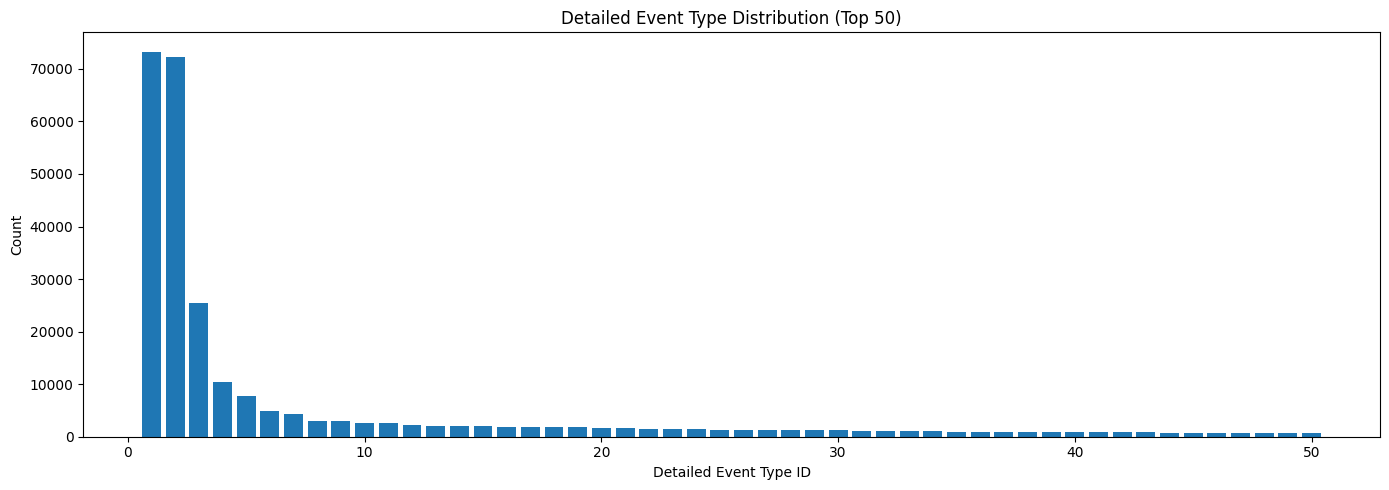

In [37]:
# Bar plot: distribution of detailed event types by id
# Note: can be large; we plot top N for readability.

import matplotlib.pyplot as plt

TOP_N = 50

ids = [row['id'] for row in lookup[:TOP_N]]
counts = [row['count'] for row in lookup[:TOP_N]]

plt.figure(figsize=(14, 5))
plt.bar(ids, counts)
plt.xlabel('Detailed Event Type ID')
plt.ylabel('Count')
plt.title(f'Detailed Event Type Distribution (Top {TOP_N})')
plt.tight_layout()
plt.show()


In [38]:
# Fixed schema: flatten every possible attribute into columns
# This builds a global column set (dot-separated paths) and reports feature count.

import json
from collections import OrderedDict

COLS = set()

# Flatten dict keys into dot paths. Lists become a single column at their path.

def add_paths(prefix, obj):
    if isinstance(obj, dict):
        for k, v in obj.items():
            add_paths(prefix + [k], v)
    elif isinstance(obj, list):
        COLS.add('.'.join(prefix))
    else:
        COLS.add('.'.join(prefix))

with DATA_PATH.open('r', encoding='utf-8') as f:
    for line in f:
        ev = json.loads(line)
        add_paths([], ev)

cols_sorted = sorted(COLS)
print('Total fixed-schema columns:', len(cols_sorted))
print('Sample columns:', cols_sorted[:50])

# Optional: build a wide dataframe (can be large). Uncomment if needed.
# import pandas as pd
# rows = []
# with DATA_PATH.open('r', encoding='utf-8') as f:
#     for line in f:
#         ev = json.loads(line)
#         flat = pd.json_normalize(ev, sep='.')
#         rows.append(flat)
# df = pd.concat(rows, ignore_index=True)
# df = df.reindex(columns=cols_sorted)
# print('DataFrame shape:', df.shape)


Total fixed-schema columns: 153
Sample columns: ['50_50', '50_50.outcome.id', '50_50.outcome.name', 'ball_receipt', 'ball_receipt.outcome.id', 'ball_receipt.outcome.name', 'ball_recovery', 'ball_recovery.offensive', 'ball_recovery.recovery_failure', 'block', 'block.deflection', 'block.offensive', 'block.save_block', 'carry', 'carry.end_location', 'clearance', 'clearance.aerial_won', 'clearance.body_part.id', 'clearance.body_part.name', 'clearance.head', 'clearance.left_foot', 'clearance.other', 'clearance.right_foot', 'counterpress', 'dribble', 'dribble.no_touch', 'dribble.nutmeg', 'dribble.outcome.id', 'dribble.outcome.name', 'dribble.overrun', 'duel', 'duel.outcome.id', 'duel.outcome.name', 'duel.type.id', 'duel.type.name', 'duration', 'event_uuid', 'foul_committed', 'foul_committed.advantage', 'foul_committed.card.id', 'foul_committed.card.name', 'foul_committed.offensive', 'foul_committed.penalty', 'foul_committed.type.id', 'foul_committed.type.name', 'foul_won', 'foul_won.advantag